In [1]:
import os,glob
import pandas as pd
import pygmt
import pickle
import warnings  
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
path    = '/Volumes/home/Research/STEP/02_Station_result_csv'
remove  = '/Volumes/home/Research/STEP/05_Station_result_statistics/V4_Remove_catalog.txt'
figpath = '/Volumes/home/Research/STEP/12_PiercePoint'

method = 'SC'
dr = pd.read_csv(remove,sep='\s+',names=['station','time','phase','a','b','c','d','e','f','g'])

In [3]:
def PygmtBegin(figmap, region, title):
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', f'nSeW+t"{title}"'])
    figmap.grdimage('@earth_relief_15s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=60)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
#     figmap.plot(data=smooth_fault,pen='1p,brown')
    Volcano = '/Volumes/home/Research/DataBase/01_Armenia/02_Volcano_list.csv'
    dv = pd.read_csv(Volcano)
    figmap.plot(x=dv['lon'],y=dv['lat'],style="kvolcano/0.4c", pen='0.1p,black', color="black")
def angle_mean(dt, phi, ddt, dphi):
    dt=np.array(dt)
    phi=np.array(phi)
    ddt=np.array(ddt)
    dphi=np.array(dphi)
    x = dt*np.cos(2*phi*np.pi/180.0)
    y = dt*np.sin(2*phi*np.pi/180.0)
    c = x + 1j*y
    m = np.mean(c)

    phase = np.angle(m, deg=True)/2.
    radius = np.abs(m)
    dphase = np.sqrt(np.sum(dphi**2))/len(x)
    dradius = np.sqrt(np.sum(ddt**2))/len(x)
    print(phase, dphase, radius, dradius)
    return phase, dphase, radius, dradius

## Histogram 

In [5]:
SC = {'neg_philist' : [],
      'neg_dtlist' : [],
      'neg2_philist' : [],
      'pos_philist' : [],
      'pos_dtlist' : [] }
RC = {'neg_philist' : [],
      'neg_dtlist' : [],
      'neg2_philist' : [],
      'pos_philist' : [],
      'pos_dtlist' : [] }
for pkl in sorted(glob.glob(f'{PKLpath}/*.pkl')):
    STApkl = pickle.load(open(pkl, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    sta = values['station'];net = values['network']
    stlat = values['latitude']; stlon = values['longitude']
    if sta == 'CMCY' or sta == 'DGRL' or net =='BI':
        pass
    else:
        for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/{net}.{sta}*result.csv')):
            df = pd.read_csv(resultpath)
            dff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]
            for i in range(len(dff)):
                event = dff['Event'].values[i]
                evlat = dff['Ev_lat'].values[i]
                evlon = dff['Ev_lon'].values[i]
                evdep = dff['Depth'].values[i]
                phase = dff['Phase'].values[i]
                if sta in dr['station'].to_list() and event in dr['time'].to_list():
                        print(f'{sta} {event}')
                else:
                    phi = dff['SCPhi'].values[i]
                    dt  = dff['SCdt'].values[i]
                    if phi > 0: 
                        SC['pos_philist'].append(phi)
                        SC['pos_dtlist'].append(dt) 
                    else: 
                        SC['neg2_philist'].append((phi+180))
                        SC['neg_philist'].append(phi)
                        SC['neg_dtlist'].append(dt) 

                    phi = dff['RCPhi'].values[i]
                    dt  = dff['RCdt'].values[i]

                    if phi > 0: 
                        RC['pos_philist'].append(phi)
                        RC['pos_dtlist'].append(dt) 
                    else: 
                        RC['neg2_philist'].append((phi+180))
                        RC['neg_philist'].append(phi)
                        RC['neg_dtlist'].append(dt) 


VAND 20150123_034727
VAND 20190731_150233
VAND 20200805_120536
VAND 20160729_211826
VAND 20180211_231415
ZARN 20180211_231415
GUDG 20131123_074832
TBLG 20130523_210746
KIV 20140326_032936
KIV 20140708_125625
KIV 20170926_042000
KIV 20181223_230843
KIV 20110726_174421
KIV 20110909_194133
GNI 20131123_074832
GNI 20130514_003226
GNI 20180828_223513
GNI 20200613_210830


In [6]:
from scipy.stats import circmean, circstd
def mean(phi, dt):
    newphi = []
    for i in phi:
        newphi.append(i*np.pi/180)
    phimean = circmean(newphi)*180/np.pi
    phistd  = circstd(newphi)*180/np.pi
    dtmean  = np.mean(dt)
    dtstd  = np.std(dt)
    print(phimean,phistd,dtmean,dtstd)
    return phimean,phistd,dtmean,dtstd
phimean,phistd,dtmean,dtstd = mean(SC['pos_philist'], SC['pos_dtlist'])
phimean,phistd,dtmean,dtstd = mean(SC['neg2_philist'], SC['neg_dtlist'])

phimean,phistd,dtmean,dtstd = mean(RC['pos_philist'], RC['pos_dtlist'])
phimean,phistd,dtmean,dtstd = mean(RC['neg2_philist'], RC['neg_dtlist'])

45.923316087 15.7365188482 1.17558139535 0.452110309269
126.050796158 21.33940034 0.94 0.390384425919
44.8915955615 12.2626110676 1.06034682081 0.404709124052
126.493986717 14.0624915739 0.788888888889 0.292287698621


In [9]:
len(SC['pos_philist'])+len(SC['neg2_philist'])

182

In [46]:
phase, dphase, radius, dradius = angle_mean(SC['pos_dtlist'], SC['pos_philist'], SC['pos_ddtlist'], SC['pos_dphilist'] )

phase, dphase, radius, dradius = angle_mean(SC['neg_dtlist'], SC['neg2_philist'], SC['neg_ddtlist'], SC['neg_dphilist'])


KeyError: 'pos_ddtlist'

100.05741810575427

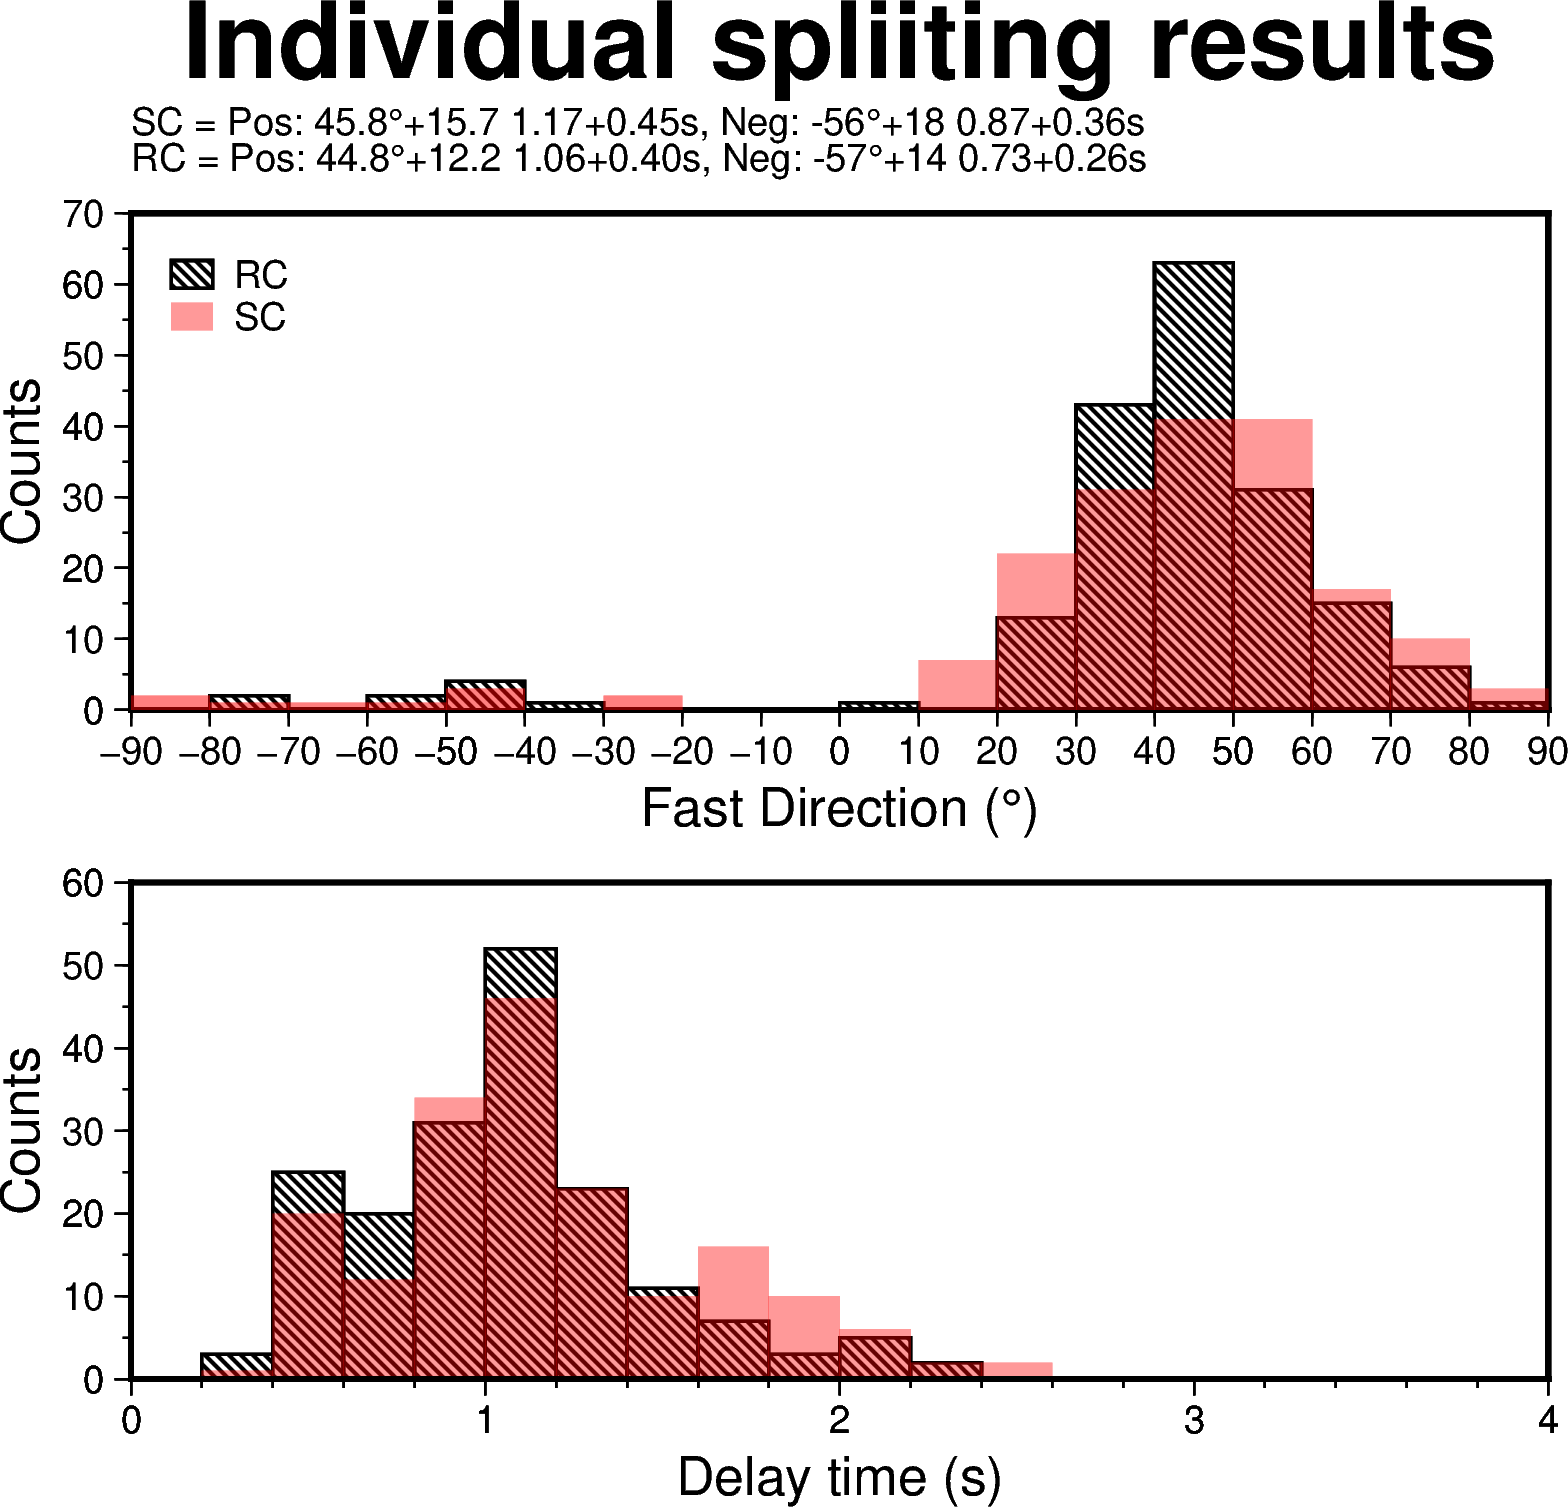

In [8]:
fig = pygmt.Figure()
# -Gp解析度/種類代碼:B背景色F前景色
with fig.subplot(nrows=2, ncols=1, figsize=("12c", "10c"), frame=["af", "WS"],
    margins=["0.1c", "0.5c"], title="Individual spliiting results",):
    fig.basemap(region=[-90, 90, 0, 70], projection="X?", frame=["xa10f10", "ya10f5", "WS"], panel=[0])

    fig.histogram(
        data=RC['pos_philist'],
        frame=[ 'x+l"Fast Direction (\\260)"', 'y+l"Counts"'],
        series=10, fill="p400/12:BblackFwhite", pen="0.8p", histtype=0, label='RC')
    fig.histogram(
        data=SC['pos_philist'],
        series=10, fill='red@60', histtype=0,label='SC')
    fig.histogram(
        data=RC['neg_philist'],
        series=10, fill="P400/12:BblackFwhite", pen="0.8p", histtype=0)  
    fig.histogram(
        data=SC['neg_philist'],
        series=10, fill='red@50', histtype=0)
    fig.legend(position='JTL+jTL+o0.2c')
    fig.text(x=-90,y=85,text='SC = Pos: 45.8\\260+15.7 1.17+0.45s, Neg: -56\\260+18 0.87+0.36s',justify='LT',no_clip=True)
    fig.text(x=-90,y=80,text='RC = Pos: 44.8\\260+12.2 1.06+0.40s, Neg: -57\\260+14 0.73+0.26s',justify='LT',no_clip=True)
    fig.basemap(region=[0, 4, 0, 60], projection="X?", frame=['xa1f0.2','ya10f5', "WS"], panel=[1, 0])
    fig.histogram(
        data=RC['pos_dtlist']+RC['neg_dtlist'],
        series=0.2, fill="p400/12:BblackFwhite", pen="0.8p", histtype=0)
    fig.histogram(
        data=SC['pos_dtlist']+SC['neg_dtlist'],
        frame=[ 'x+l"Delay time (s)"', 'y+l"Counts"'],
        series=0.2, fill='red@60', histtype=0)


fig.show()
fig.savefig('Histogram_2method_v2.png',dpi=300)
fig.savefig('Histogram_2method_v2.pdf',dpi=300)